## This notebook is being used to draft potential figures for a manuscript publishing this package

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
palette = sns.color_palette()
sns.set_style("whitegrid", {'axes.grid' : False})
# import bayesian estimation package
import ndim_homogeneous_distinguishability as hd

### Generating functions
Let's pack all the functions used to generate figures up towards the top, so we can easily scroll from figure to figure without being distracted by too many big code blocks.

In [203]:
def plot_2D_ex_traj(D, c):
    df = hd.simulate_diffusion_df(n_dim = 2, d_const = D, n_steps = 100, dt = 1, loc_std = 0.02)
    if c==1:
        c1 = palette[0]
        c2 = palette[1]
    else:
        c1 = palette[2]
        c2 = palette[3]
    plt.plot([x[0] for x in df['x']], [x[1] for x in df['x']], label='True', color=c1)
    plt.plot([x[0] for x in df['x']], [x[1] for x in df['x_obs']], label='Observed', color=c2);
    plt.xlabel(r'x ($\mu$m)')
    plt.ylabel(r'y ($\mu$m)')
    plt.legend();
    return df

In [204]:
def draw_all_posteriors(df1, df2, D1, D2):
    
    posterior1t,_a,_b = hd.estimate_diffusion(n_dim = 2, dt = 1, dr = df1['dr'])
    posterior1o,_a,_b = hd.estimate_diffusion(n_dim = 2, dt = 1, dr = df1['dr_obs'])
    posterior2t,_a,_b = hd.estimate_diffusion(n_dim = 2, dt = 1, dr = df2['dr'])
    posterior2o,_a,_b = hd.estimate_diffusion(n_dim = 2, dt = 1, dr = df2['dr_obs'])
    
    xx = np.linspace(D1-6*posterior1o.std(),D2+6*posterior2o.std(), 50)
    
    plt.plot(xx, posterior1t.pdf(xx), color = palette[0], label = 'D1 True')
    plt.plot(xx, posterior1o.pdf(xx), color = palette[1], label='D1 Observed')
    plt.plot(xx, posterior2t.pdf(xx), color = palette[2], label='D2 True')
    plt.plot(xx, posterior2o.pdf(xx), color = palette[3], label='D2 Observed')
    plt.axvline(x=D1, linestyle=':', color='gray')
    plt.axvline(x=D2, linestyle=':', color='gray')
    plt.legend()
    plt.xlabel('Diffusion Constant')
    plt.ylabel('Probability density');

In [205]:
def simulate_diffusion_error(n_dim, d_const, n_steps, dt, err_list):
    
    df = pd.DataFrame()
    np.random.seed()

    # initialize position at origin
    x0 = list(np.zeros(n_dim))
    x = x0
    x_list = [x]
    for t in range(n_steps-1):
        dx = [np.sqrt(2*d_const*dt)*np.random.randn() for _dim in range(n_dim)]
        x_new = [sum(i) for i in zip(x, dx)]
        x_list.append(x_new)
        x = x_new
    df['0'] = x_list
    
    for err in err_list:
        xo_list = []
        for t in range(n_steps):
            x_obs = [x_list[t][i] + err*np.random.randn() for i in range(n_dim)]
            xo_list.append(x_obs)
        df[str(err)] = xo_list
    
    palette = sns.cubehelix_palette(rot=-.4, n_colors = len(err_list)+1)
    #palette = sns.color_palette("YlGn", len(err_list)+1)
    
    for n in range(len(err_list)):
        err = err_list[len(err_list)-n-1]
        plt.plot([x[0] for x in df[str(err)]], [x[1] for x in df[str(err)]], label=str(err), color=palette[n])
    plt.plot([x[0] for x in df['0']], [x[1] for x in df['0']], label='0', marker='o', color=palette[len(err_list)])
    plt.xlabel(r'x ($\mu$m)')
    plt.ylabel(r'y ($\mu$m)')
    plt.legend();
    
    # save figure to file for manuscript
    plt.savefig('trajectory_multierror.png')
        
    return df

### Figure drafts

First we deomonstrate a diffusive trajectory with varying levels of localization error

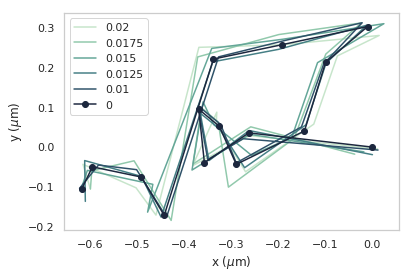

In [257]:
D1 = 0.01
err_list = [0.01, 0.0125, 0.015, 0.0175, 0.02]
df = simulate_diffusion_error(2, D1, 15, 1, err_list)

In [ ]:
df1, df2, df3 = hd.error_sensitivity(d_const=0.1, n_steps_list=[10, 25, 50, 100, 150, 200, 500], dt=1, n_reps=10**4, loc_std=[0, 0.005, 0.01, 0.025, 0.05, 0.1, 0.2])

In [ ]:
df11 = df1.drop(columns=df1.columns[6])
df22 = df2.drop(columns=df2.columns[6])
df33 = df3.drop(columns=df3.columns[6])

size = 8
fig4, axs = plt.subplots(1,3, figsize=(3*size,size))
    
sb.heatmap(df11, ax=axs[0], cmap='viridis', vmin=0, vmax=25);
axs[0].set(xlabel = 'Error St Dev', ylabel = 'Trajectory length (T)', title='Dim = 1');
axs[0].invert_yaxis()
    
sb.heatmap(df22, ax=axs[1], cmap='viridis', vmin=0, vmax=25);
axs[1].set(xlabel = 'Error St Dev', ylabel = 'Trajectory length (T)', title='Dim = 2');
axs[1].invert_yaxis()

sb.heatmap(df33, ax=axs[2], cmap='viridis', vmin=0, vmax=25);
axs[2].set(xlabel = 'Error St Dev', ylabel = 'Trajectory length (T)', title='Dim = 3');
axs[2].invert_yaxis()

We can then select a localization error level and show two trajectories with the same localization error but different diffusion constants

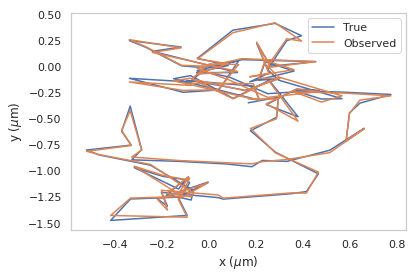

In [263]:
df1 = plot_2D_ex_traj(D1, 1)

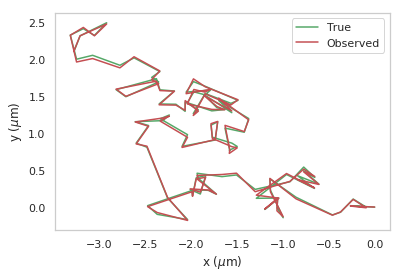

In [264]:
D2 = 1.5*D1
df2 = plot_2D_ex_traj(D2, 2)

Once we've finalized these, the grids will have to be scales so that D1 and D2 trajectories are on a comparable spatial/viz scale.

We can show the differences in posterior for both (1) the same diffusion constant with and without error and (2) the same for a differing diffusion constant. This opens us up to talk about eithor error in the posterior due to localization error and trajectory length (first) or posterior overlap and distinguishability (second). 

In [ ]:
draw_all_posteriors(df1, df2, D1, D2)
plt.savefig('posteriors')

For either the first or the second of these options, heatmaps serving as potential figure mockups are located in the tutorial notebook.

In [5]:
n_steps = [5, 25, 50, 100, 200, 500, 1000]
# set diffusion constant multipliers to sweep through (D2 = mult*D1)
d_const1 = 0.01
Mmin = 1.0
Mmax = 15.
numM = 30
mult_list = np.logspace(np.log10(Mmin), np.log10(Mmax), numM)

# set trajectory lengths, timestep, and number of rep's on each D
dt = 1
n_reps = 10**3

In [ ]:
# get df of pairwise KL divergence for each pair (D, mult*D)
KL_sweep_df_T = hd.fill_heatmap_gen(n_dim=3, d_const=d_const1, mult_list=mult_list, n_steps=n_steps, dt=dt, n_reps=n_reps)

In [ ]:
# and plot that df as a heatmap of KL divergence values, and the log of the KL divergence values
x_lab = 'Trajectory Length T'
y_lab = r'$D_2/D_1$'
t1 = 'KL Divergence'
t2 = 'Log10(KL Divergence)'
hd.plot_df_results(df1=KL_sweep_df_T, df2=np.log10(KL_sweep_df_T), n_round=2, n_ticks=12, size=8, title1=t1, title2=t2, x_lab=x_lab, y_lab=y_lab, title='KL_T_D2D1')